In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import datetime
from dateutil.relativedelta import relativedelta
import time

from cartopy import crs as ccrs, feature as cfeature
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
import glob, os
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'
import xskillscore as xs

from eofs.xarray import Eof
from eofs.standard import Eof as sEof # If needed
from eofs.multivariate.standard import MultivariateEof

from scipy import stats
import statsmodels.api as sm

sp = ccrs.SouthPolarStereo()
pc = ccrs.PlateCarree()
import matplotlib.patches as mpatches

In [2]:
# LOAD SIC: 1x0.5
filename = '/d6/bxw2101/model_files/datasets/sic_1x0p5.nc'
sic_anom_ds = xr.open_dataset(filename)
sic_anom = sic_anom_ds.sic_anom_smoothed

# LOAD 6 (for now) other model variables: 2x2
filename = '/d6/bxw2101/model_files/datasets/vars_2x2.nc'
vars_2x2 = xr.open_dataset(filename)
sst_anom = vars_2x2.sst_anom_smoothed    # 1
sat_anom = vars_2x2.sat_anom_smoothed    # 2
z_anom = vars_2x2.z_anom_smoothed        # 3
u_anom = vars_2x2.u_anom_smoothed        # 4
v_anom = vars_2x2.v_anom_smoothed        # 5
sthf_anom = vars_2x2.sthf_anom_smoothed  # 6

In [19]:
# Defining the different regions in the Antarctic:
dp1_region = (sic_anom.y >= -70) & (sic_anom.y <= -60) & (sic_anom.x >= 210) & (sic_anom.x <= 230)
dp2_region = (sic_anom.y >= -68) & (sic_anom.y <= -58) & (sic_anom.x >= 320) & (sic_anom.x <= 340)
entire_region = True
# my own:
e1_region = (sic_anom.y >= -68) & (sic_anom.y <= -58) & (sic_anom.x >= 0) & (sic_anom.x <= 20)
e2_region = (sic_anom.y >= -68) & (sic_anom.y <= -58) & (sic_anom.x >= 20) & (sic_anom.x <= 40)
e3_region = (sic_anom.y >= -68) & (sic_anom.y <= -58) & (sic_anom.x >= 40) & (sic_anom.x <= 60)
e4_region = (sic_anom.y >= -68) & (sic_anom.y <= -58) & (sic_anom.x >= 140) & (sic_anom.x <= 160)
w_h = sic_anom.x >= 181
e_h = sic_anom.x <= 180

# define validpoints: Ocean water where there is non-zero sea ice concentration > 5% of the time
filename = '/d6/bxw2101/combined_netcdf_files/new_cdr_sic_monthly_1x0p5.nc'
sic_ds = xr.open_dataset(filename)
sic_var = sic_ds.sic
# freq: Percent of time steps with any valid sea ice value.
freq = sic_var.isel(tdim=slice(2, 518)).where((sic_var < 2.51) & (sic_var > 0)).count(dim='tdim')/516
validpoints = (freq > 0.05)

def show_rectangle(ax, x, y, w, h):
    ax.add_patch(mpatches.Rectangle(xy=[x, y], width=w, height=h, 
                                    facecolor='blue', alpha=1, transform=pc, fill=None))
    return ax

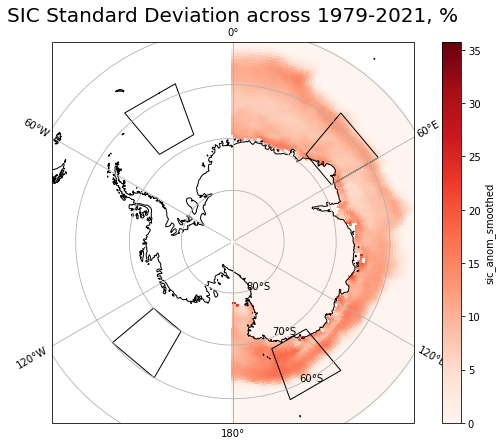

In [20]:
map_sic_std = sic_anom.where(e_h).std(dim='tdim')

# Plot where the region is:
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection=sp)
(map_sic_std * 100).plot(transform=pc, cmap='Reds') 
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
show_rectangle(ax, 210, -70, 20, 10) #dp1 region
show_rectangle(ax, 320, -68, 20, 10) #dp2 region
#show_rectangle(ax, 20, -68, 20, 10) #e2 region
show_rectangle(ax, 40, -68, 20, 10) #e3 region
show_rectangle(ax, 140, -68, 20, 10) #e4 region

ax.set_title('SIC Standard Deviation across 1979-2021, %', fontsize = 20)
plt.show()

# STD maps comparing first 20 and last 20

In [16]:
def std_map_comp(var_anom, var_name, std_max_ish, std_diff_ish):
    fig = plt.figure(figsize=(20, 6))
    fig.suptitle(f'{var_name} STD map between periods', fontsize=30)
    var_obs_h = var_anom.isel(tdim=slice(12, 516)).where(validpoints) # Chop off 1979.
    first_half = var_obs_h.isel(tdim=slice(0, 252)) # 1980-2000
    second_half = var_obs_h.isel(tdim=slice(253, 512)) #2001-2021

    ax = plt.subplot(1, 3, 1, projection=sp)
    first_half.std(dim='tdim').plot(transform=pc, cmap = 'plasma', vmin = 0, vmax = std_max_ish) 
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
    ax.set_title('1980-2000', fontsize = 20)

    ax = plt.subplot(1, 3, 2, projection = sp)
    second_half.std(dim='tdim').plot(transform=pc, cmap = 'plasma', vmin = 0, vmax = std_max_ish) 
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
    ax.set_title('2001-2021', fontsize = 20)

    diff_map_sic_std = first_half.std(dim='tdim') - second_half.std(dim='tdim')
    ax = plt.subplot(1, 3, 3, projection = sp)
    diff_map_sic_std.plot(transform=pc, cmap = 'bwr', vmin = -std_diff_ish, vmax = std_diff_ish) 
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
    ax.set_title('First Half - Second Half', fontsize = 20)
    show_rectangle(ax, 210, -70, 20, 10) #dp1 region
    show_rectangle(ax, 320, -68, 20, 10) #dp2 region
    show_rectangle(ax, 40, -68, 20, 10) #e3 region
    show_rectangle(ax, 140, -68, 20, 10) #e4 region

    plt.tight_layout()
    plt.show()

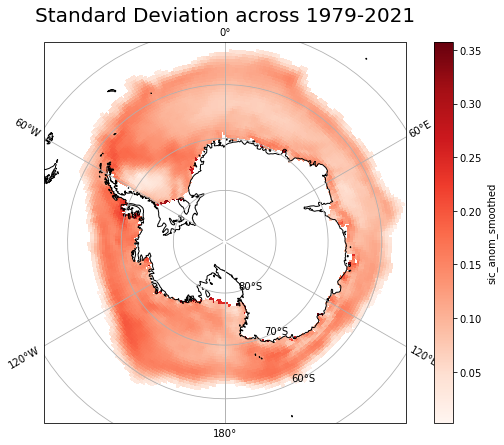

In [17]:
# This gives the entire STD map for one variable.

map_std = sic_anom.where(validpoints).std(dim='tdim')

# Plot where the region is:
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection=sp)
map_std.plot(transform=pc, cmap='Reds') 
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)

ax.set_title('Standard Deviation across 1979-2021', fontsize = 20)
plt.show()

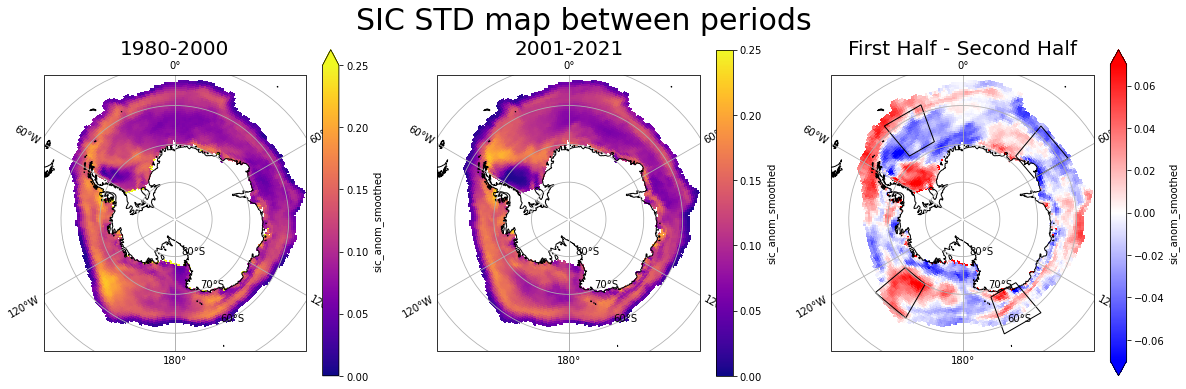

In [14]:
# SIC STD Map
var_anom = sic_anom
sic_name = "SIC"
std_max_ish = .25
std_diff_ish = .7

std_map_comp(sic_anom, "SIC", 0.25, 0.07)

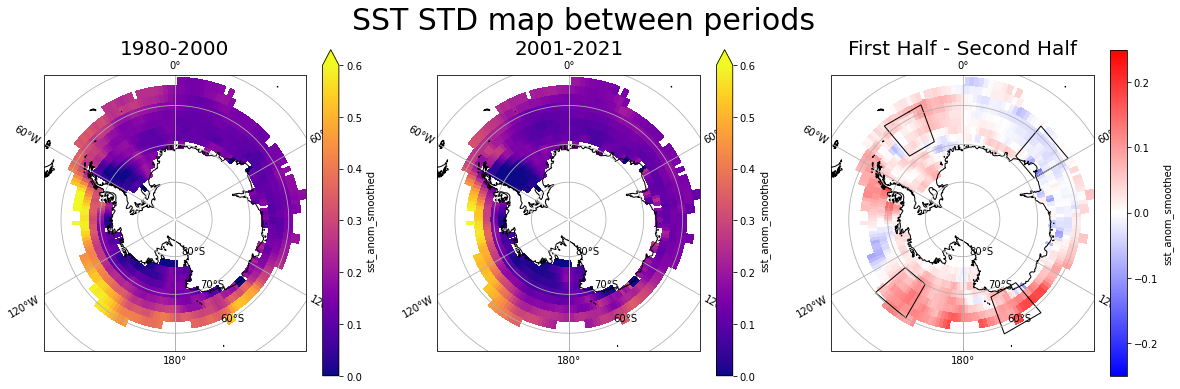

In [18]:
# SST STD Map
std_map_comp(sst_anom, "SST", 0.6, 0.25)

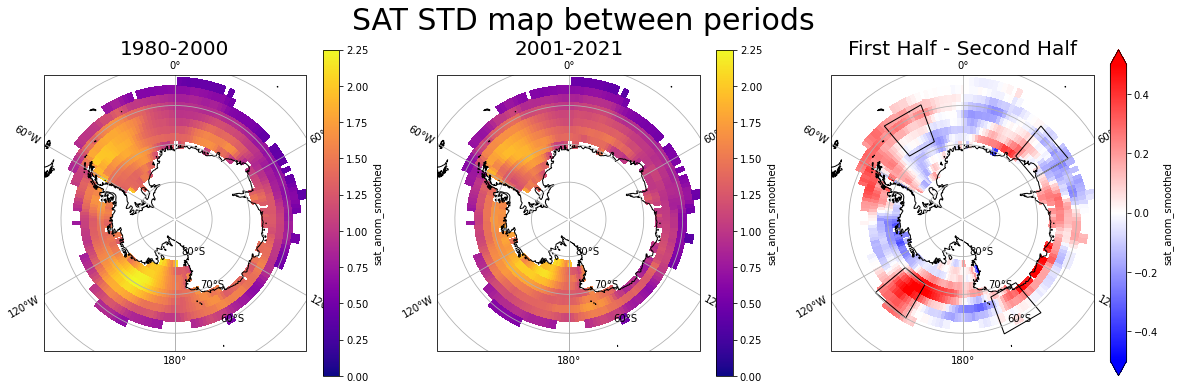

In [32]:
std_map_comp(sat_anom, "SAT", 2.25, 0.5)

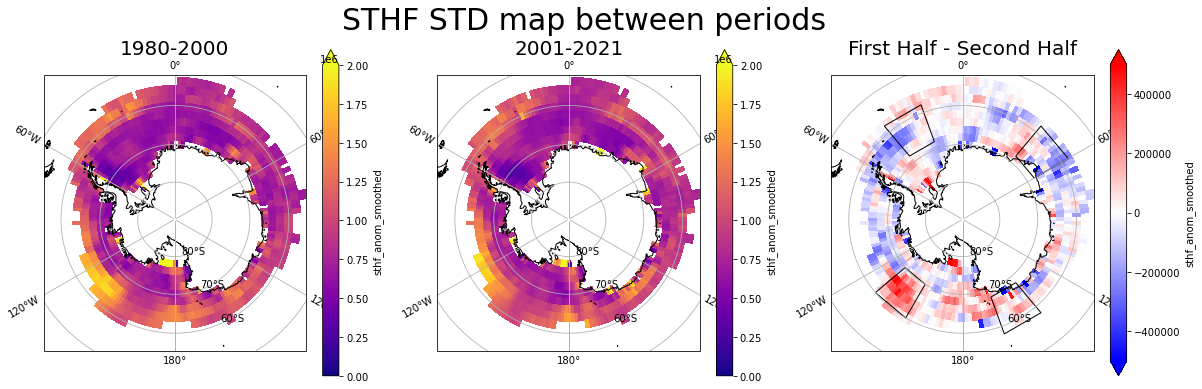

In [19]:
# STHF STD Map
std_map_comp(sthf_anom, "STHF", 2000000, 500000)

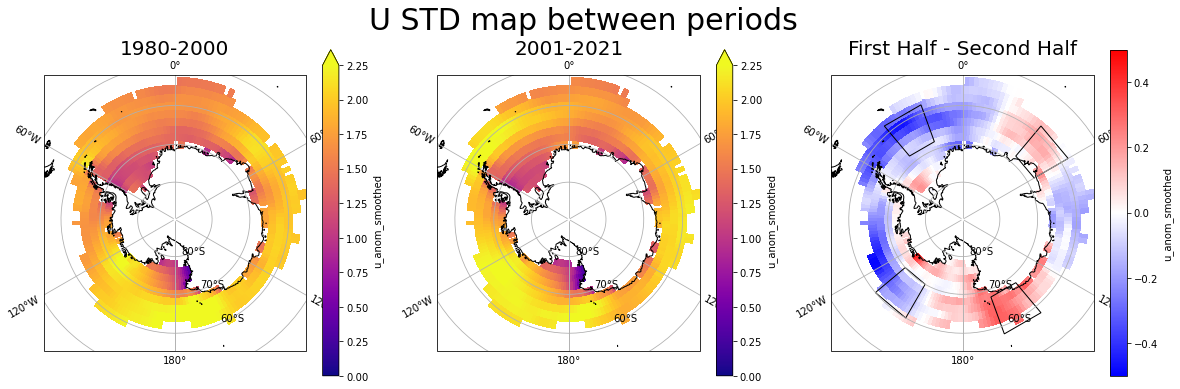

In [22]:
std_map_comp(u_anom, "U", 2.25, 0.5)

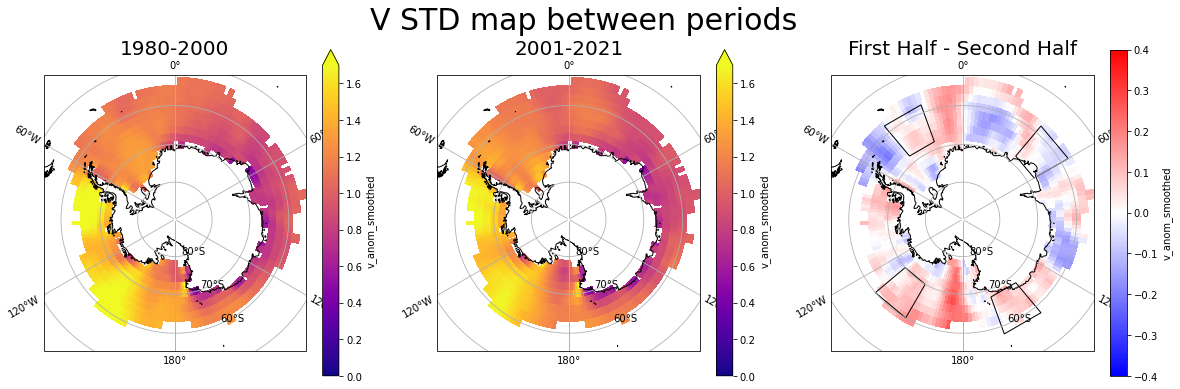

In [13]:
std_map_comp(v_anom, "V", 1.7, 0.4)

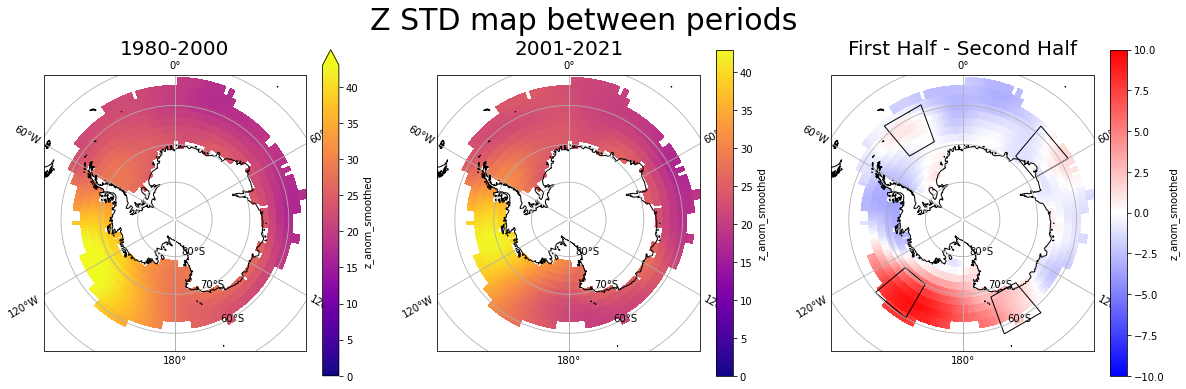

In [27]:
std_map_comp(z_anom, "Z", 43, 10)

# Persistence map for SIC

In [55]:
def persistence_map_comp(var_anom, var_name, leadtime, p_diff_range):
    fig = plt.figure(figsize=(20, 6))
    fig.suptitle(f'{var_name} Persistence, with lead time = {leadtime}, comparing periods', fontsize=30)
    var_obs_h = var_anom.isel(tdim=slice(12, 516)).where(validpoints) # Chop off 1979.
    first_half = var_obs_h.isel(tdim=slice(0, 252)) # 1980-2000
    second_half = var_obs_h.isel(tdim=slice(253, 512)) #2001-2021

    p_1 =xr.corr(first_half, first_half.shift(tdim=-leadtime), dim='tdim')
    p_2 =xr.corr(second_half, second_half.shift(tdim=-leadtime), dim='tdim')

    ax = plt.subplot(1, 3, 1, projection=sp)
    p_1.plot(transform=pc, cmap = 'gist_rainbow', vmin = 0, vmax = 1) 
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
    ax.set_title('1980-2000', fontsize = 20)

    ax = plt.subplot(1, 3, 2, projection = sp)
    p_2.plot(transform=pc, cmap = 'gist_rainbow', vmin = 0, vmax = 1) 
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
    ax.set_title('2001-2021', fontsize = 20)

    diff_map_persistence = p_1 - p_2
    ax = plt.subplot(1, 3, 3, projection = sp)
    diff_map_persistence.plot(transform=pc, cmap = 'bwr', vmin = -p_diff_range, vmax = p_diff_range) 
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
    ax.set_title('First Half - Second Half', fontsize = 20)
    show_rectangle(ax, 210, -70, 20, 10) #dp1 region
    show_rectangle(ax, 320, -68, 20, 10) #dp2 region
    show_rectangle(ax, 40, -68, 20, 10) #e3 region
    show_rectangle(ax, 140, -68, 20, 10) #e4 region

    plt.tight_layout()
    plt.show()

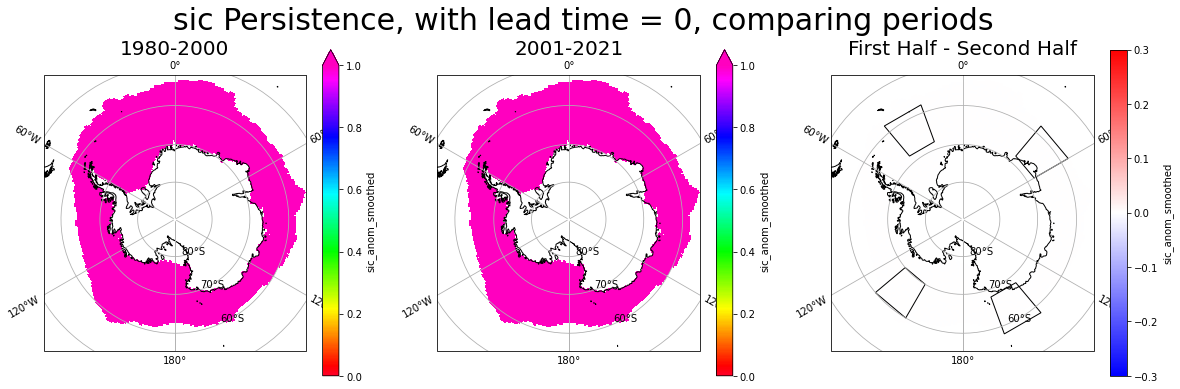

In [9]:
persistence_map_comp(sic_anom, "sic", 0, 0.3)

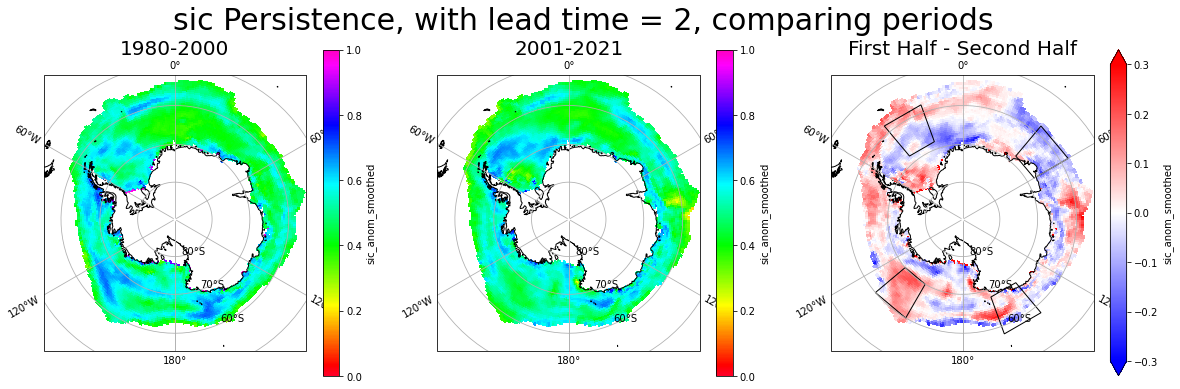

In [11]:
persistence_map_comp(sic_anom, "sic", 2, 0.3)

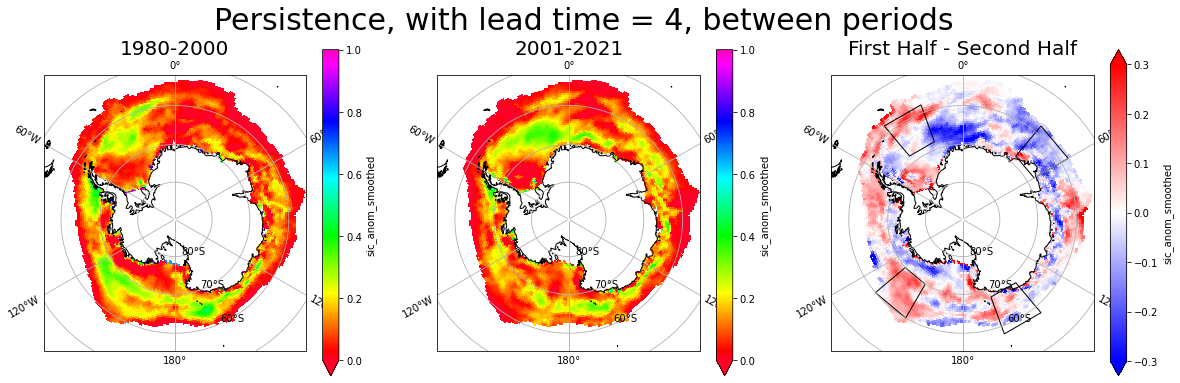

In [65]:
persistence_map_comp(sic_anom, "sic", 4, 0.3)

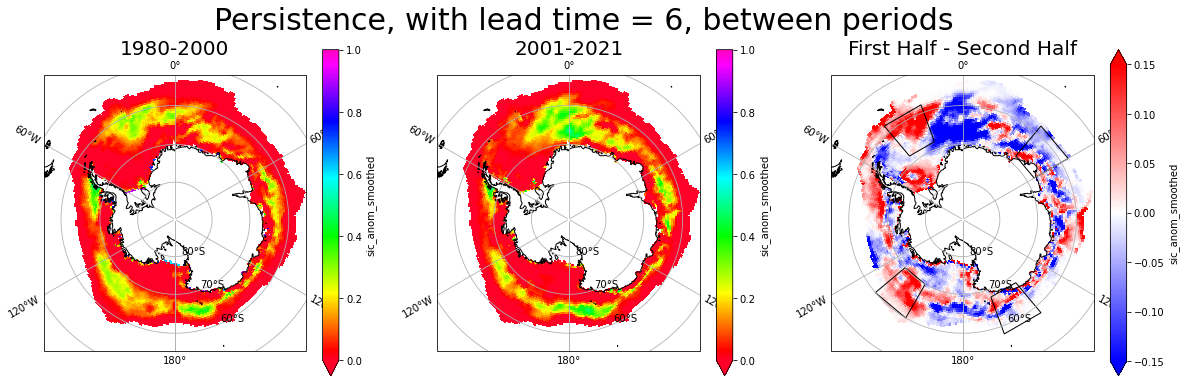

In [67]:
persistence_map_comp(sic_anom, "sic", 6, 0.3)

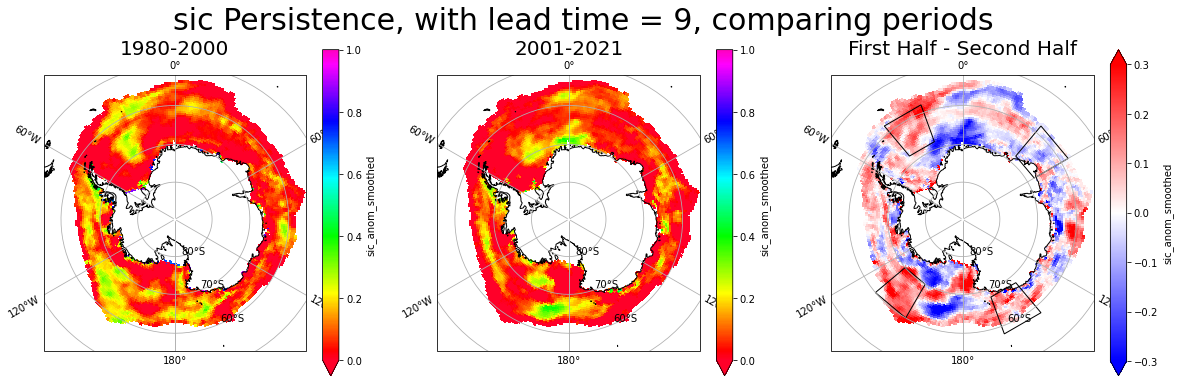

In [58]:
persistence_map_comp(sic_anom, "sic", 9, 0.3)

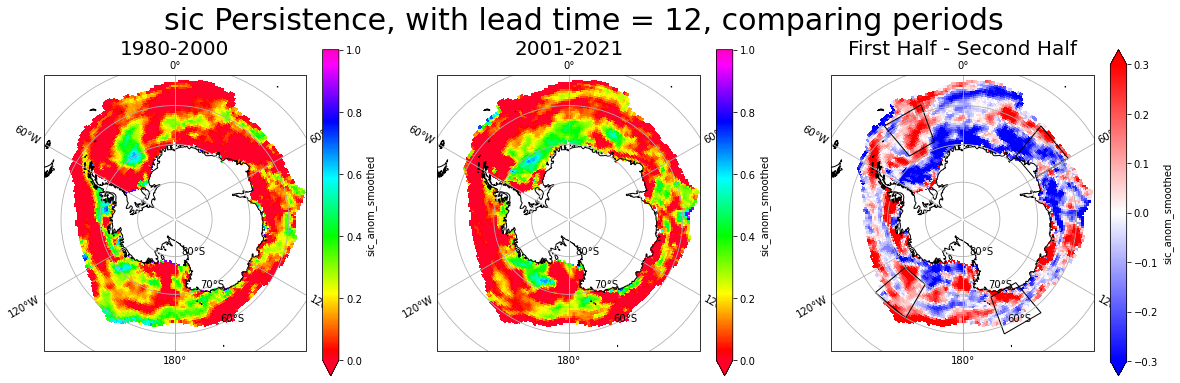

In [57]:
persistence_map_comp(sic_anom, "sic", 12, 0.3)

## SST?

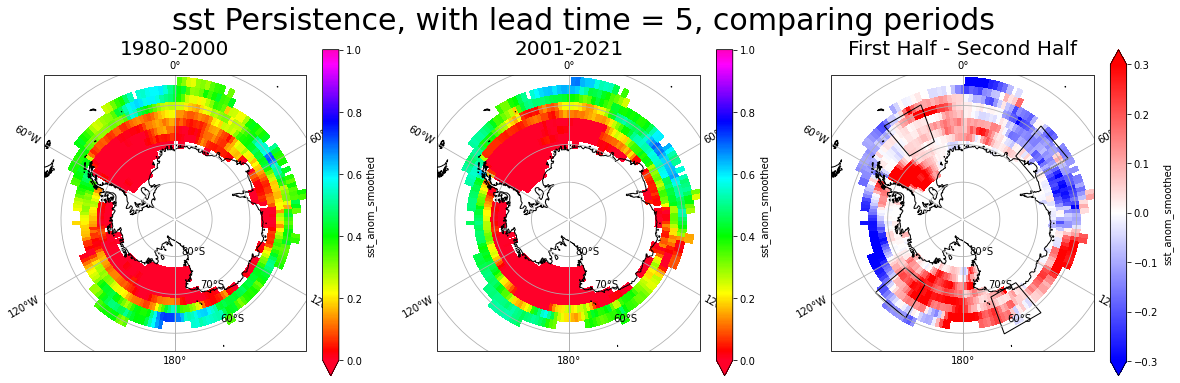

In [76]:
persistence_map_comp(sst_anom, "sst", 5, 0.3)

# West v East Persistence

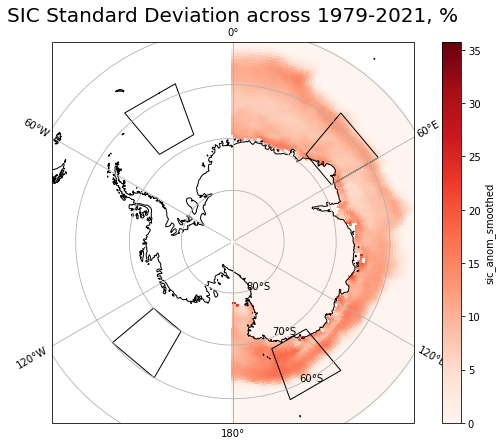

In [47]:
map_sic_std = sic_anom.where(e_h).std(dim='tdim')

# Plot where the region is:
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection=sp)
(map_sic_std * 100).plot(transform=pc, cmap='Reds') 
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
show_rectangle(ax, 210, -70, 20, 10) #dp1 region
show_rectangle(ax, 320, -68, 20, 10) #dp2 region
#show_rectangle(ax, 20, -68, 20, 10) #e2 region
show_rectangle(ax, 40, -68, 20, 10) #e3 region
show_rectangle(ax, 140, -68, 20, 10) #e4 region

ax.set_title('SIC Standard Deviation across 1979-2021, %', fontsize = 20)
plt.show()

## Averaged anomaly within hemisphere first into one ts, then persistence taken.

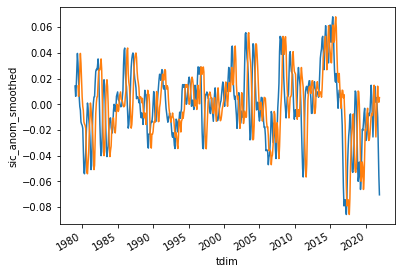

In [50]:
western_anom_mean.plot()
western_anom_mean.shift(tdim=5).plot()

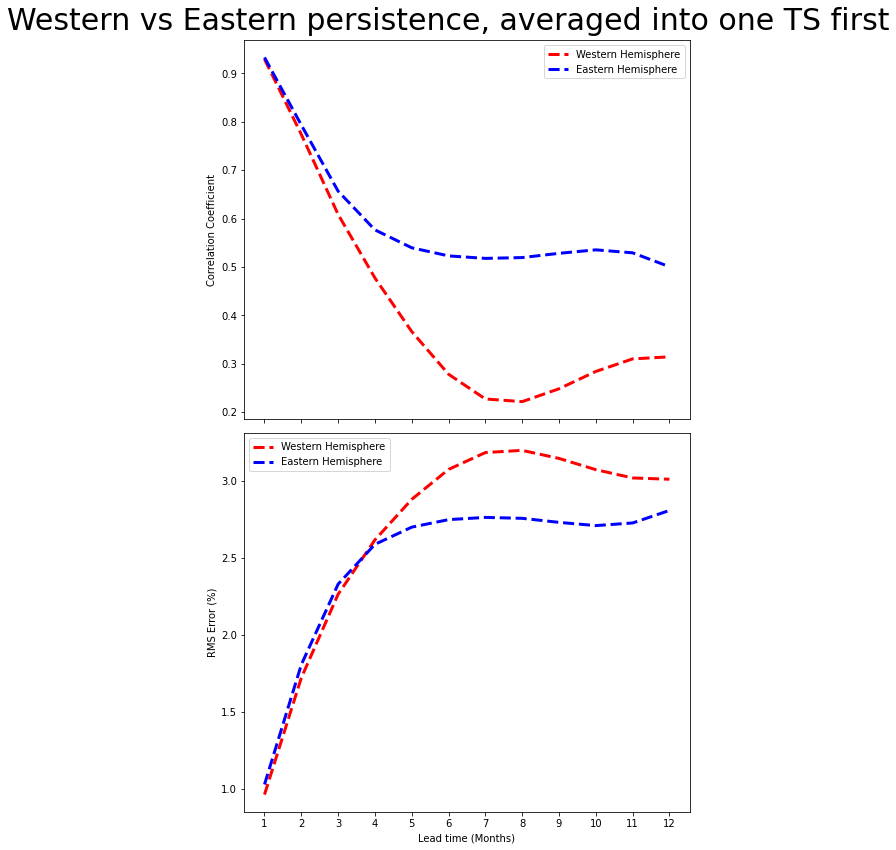

In [59]:
western_anom = sic_anom.where(w_h).where(validpoints)
eastern_anom = sic_anom.where(e_h).where(validpoints)
western_anom_mean = western_anom.mean(dim=['x','y'])
eastern_anom_mean = eastern_anom.mean(dim=['x','y'])

w_persistence_c = np.zeros(12)
w_persistence_r = np.zeros(12)
e_persistence_c = np.zeros(12)
e_persistence_r = np.zeros(12)
for lag in range(1,13):
    w_persistence_c[lag-1] = xr.corr(western_anom_mean.shift(tdim=-lag), western_anom_mean, dim='tdim').data
    w_persistence_r[lag-1] = xs.rmse(western_anom_mean.shift(tdim=-lag), western_anom_mean, dim='tdim', skipna=True).data
    e_persistence_c[lag-1] = xr.corr(eastern_anom_mean.shift(tdim=-lag), eastern_anom_mean, dim='tdim').data
    e_persistence_r[lag-1] = xs.rmse(eastern_anom_mean.shift(tdim=-lag), eastern_anom_mean, dim='tdim', skipna=True).data

fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_figheight(12)
fig.set_figwidth(7)
fig.suptitle("Western vs Eastern persistence, averaged into one TS first", fontsize=30)
xticks = np.arange(1, 13)
axs[0].set_xticks(xticks)
axs[0].set_ylabel('Correlation Coefficient')
axs[1].set_ylabel('RMS Error (%)')

axs[0].plot(xticks, w_persistence_c, linewidth = 3, color = 'red', linestyle='dashed')
axs[0].plot(xticks, e_persistence_c, linewidth = 3, color = 'blue', linestyle='dashed')
axs[0].legend(['Western Hemisphere', 'Eastern Hemisphere'])

# Plot rmse and the rmse persistence
axs[1].plot(xticks, w_persistence_r * 100, linewidth = 3, color='red', linestyle='dashed')
axs[1].plot(xticks, e_persistence_r * 100, linewidth = 3, color = 'blue', linestyle='dashed')
axs[1].legend(['Western Hemisphere', 'Eastern Hemisphere'])
axs[1].set_xlabel('Lead time (Months)')

plt.tight_layout()

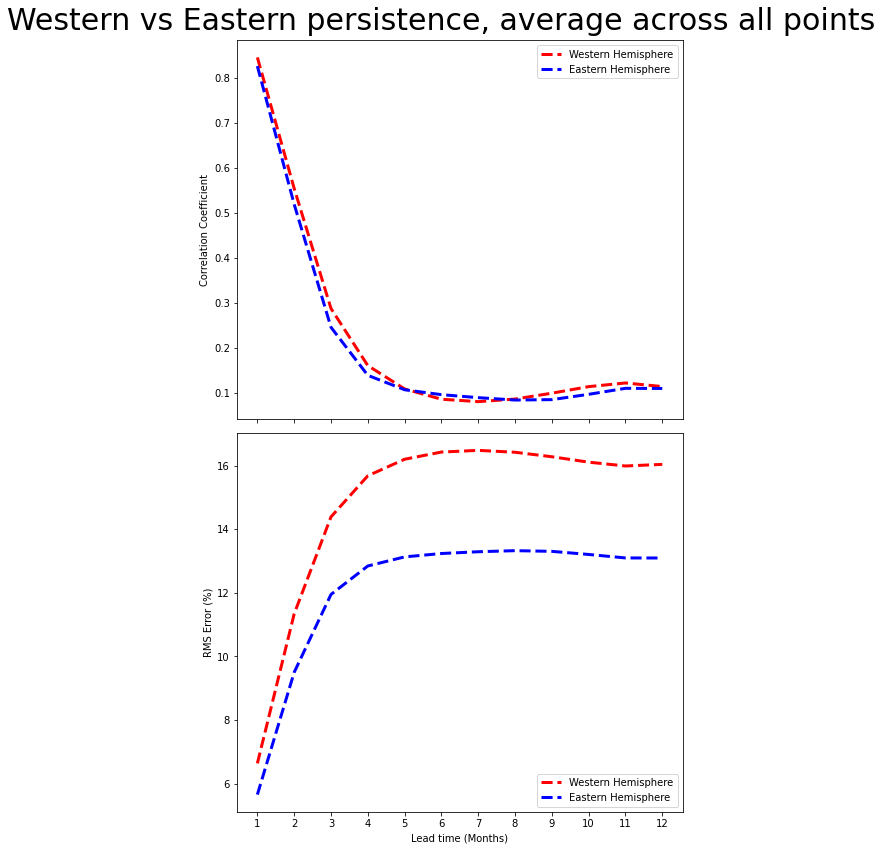

In [61]:
western_anom = sic_anom.where(w_h).where(validpoints)
eastern_anom = sic_anom.where(e_h).where(validpoints)
western_anom_mean = western_anom.mean(dim=['x','y'])
eastern_anom_mean = eastern_anom.mean(dim=['x','y'])

w_persistence_c = np.zeros(12)
w_persistence_r = np.zeros(12)
e_persistence_c = np.zeros(12)
e_persistence_r = np.zeros(12)
for lag in range(1,13):
    w_persistence_c[lag-1] = xr.corr(western_anom.shift(tdim=-lag), western_anom, dim='tdim').mean()
    w_persistence_r[lag-1] = xs.rmse(western_anom.shift(tdim=-lag), western_anom, dim='tdim', skipna=True).mean()
    e_persistence_c[lag-1] = xr.corr(eastern_anom.shift(tdim=-lag), eastern_anom, dim='tdim').mean()
    e_persistence_r[lag-1] = xs.rmse(eastern_anom.shift(tdim=-lag), eastern_anom, dim='tdim', skipna=True).mean()

fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_figheight(12)
fig.set_figwidth(7)
fig.suptitle("Western vs Eastern persistence, average across all points", fontsize=30)
xticks = np.arange(1, 13)
axs[0].set_xticks(xticks)
axs[0].set_ylabel('Correlation Coefficient')
axs[1].set_ylabel('RMS Error (%)')

axs[0].plot(xticks, w_persistence_c, linewidth = 3, color = 'red', linestyle='dashed')
axs[0].plot(xticks, e_persistence_c, linewidth = 3, color = 'blue', linestyle='dashed')
axs[0].legend(['Western Hemisphere', 'Eastern Hemisphere'])

# Plot rmse and the rmse persistence
axs[1].plot(xticks, w_persistence_r * 100, linewidth = 3, color='red', linestyle='dashed')
axs[1].plot(xticks, e_persistence_r * 100, linewidth = 3, color = 'blue', linestyle='dashed')
axs[1].legend(['Western Hemisphere', 'Eastern Hemisphere'])
axs[1].set_xlabel('Lead time (Months)')

plt.tight_layout()